In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Preparacion de Datos

In [2]:
# Update the paths to point to your image directories with forward slashes
base_dir = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/image_set'  # Base directory
train_dir = base_dir + r'/train'
val_dir = base_dir + r'/val'
test_dir = base_dir + r'/test'

In [3]:
# Image data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')


In [4]:
# Validation and test data generators without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [5]:
# Load the training data with target size set to 256x256 (since your images are already that size)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), 
                                                    batch_size=32, class_mode='categorical')


Found 1814 images belonging to 20 classes.


In [6]:
# Load the validation data with target size 256x256
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(256, 256), 
                                                batch_size=32, class_mode='categorical')


Found 408 images belonging to 20 classes.


In [7]:
# Load test data with target size 256x256
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), 
                                                  batch_size=32, class_mode='categorical')

Found 381 images belonging to 20 classes.


## Entrenamiento del Modelo

In [8]:
# Load the Xception model as a base (pretrained on ImageNet)
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models


In [9]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  # Freeze the pretrained model layers


In [10]:
# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])


In [11]:
from tensorflow.keras.optimizers import Adam

# Set a lower learning rate (default is usually 0.001)
low_lr = 0.0005  # This is slower than the default

# Compile the model with the adjusted learning rate
model.compile(optimizer=Adam(learning_rate=low_lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Display the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        20,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,980,156 (87.66 MB)

 Trainable params: 2,118,676 (8.08 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [13]:
# basado en el analisis del modelo, ajustamos los weights de algunas clases
class_weights = {
    0: 0.8,   # Airplane
    1: 1.0,   # Ambulance
    2: 1.0,   # Bicycle
    3: 1.0,   # Boat
    4: 1.0,   # Bus
    5: 1.0,   # Car
    6: 1.0,   # Fire Truck
    7: 1.0,   # Helicopter
    8: 1.0,   # Hovercraft
    9: 0.8,   # Jet Ski
    10: 1.0,  # Kayak
    11: 0.8,  # Motorcycle
    12: 1.0,  # Rickshaw
    13: 1.0,  # Scooter
    14: 1.0,  # Segway
    15: 1.0,  # Skateboard
    16: 1.0,  # Tractor
    17: 1.0,  # Truck
    18: 1.0   # Unicycle
}



Le subimos las epocas a 50 con un early stop de 3, (se puede subir a mas para tener mejor precision por lo que parece)

In [14]:
# Train the model
#history = model.fit(train_generator, epochs=5, validation_data=val_generator)

from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_generator, 
                    epochs=7, 
                    validation_data=val_generator, 
                    class_weight=class_weights
                    )

Epoch 1/50


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.4914 - loss: 1.7943 - val_accuracy: 0.8824 - val_loss: 0.4125
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.8447 - loss: 0.5292 - val_accuracy: 0.8873 - val_loss: 0.3620
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.8452 - loss: 0.4947 - val_accuracy: 0.8922 - val_loss: 0.3441
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.8721 - loss: 0.4104 - val_accuracy: 0.9069 - val_loss: 0.3278
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.8856 - loss: 0.3487 - val_accuracy: 0.9044 - val_loss: 0.3087
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.8730 - loss: 0.3723 - val_accuracy: 0.9044 - val_loss: 0.3288
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.8954 - loss: 0.3090 - val_accuracy: 0.9118 - val_loss: 0.2711
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.8994 - loss: 0.2659 - val_accuracy: 0.9167 - val_loss: 0.

KeyboardInterrupt: 

In [15]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')


12/12 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9372 - loss: 0.2046
Test accuracy: 0.9291338324546814


## Guardar/Cargar Modelos

In [19]:
# guardar el modelo
model.save('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_opening_latino(HD).keras')

# cargar el modelo
from tensorflow.keras.models import load_model
model1 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos.keras')
model2 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights.keras')
model3 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights_learning_rate0005.keras')
model4 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_con_weights_learning_rate0005_final(no_final).keras')
model5 = load_model('C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/Modelos/vehiculos_opening_latino(HD).keras')

c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Predicciones

In [9]:
# Predict on a single image
from tensorflow.keras.preprocessing import image
import numpy as np


In [19]:
img_path = r'C:/Users/diego/Downloads/download.jpg'  # Update this path
img = image.load_img(img_path, target_size=(256, 256))  # Adjust to 256x256
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])
print(f'Predicted class: {predicted_class}')


In [ ]:
label_list = train_generator.class_indices
# Invertimos el diccionario para que podamos buscar los nombres de las clases por índice
label_list = {v: k for k, v in label_list.items()}
predicted_label = label_list[predicted_class]
print(f'This vehicle is predicted to be a: {predicted_label}')


## Analisis del modelo

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Data loading and preparation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Disable shuffling for evaluation
)
# Get the true class labels from the test generator
true_classes = test_generator.classes

# Get the class labels (class names)
class_labels = list(test_generator.class_indices.keys())


# desde acá
# vehiculos.kera
# Generate predictions on the test set
predictions1 = model1.predict(test_generator)
# Convert predictions to class indices
predicted_classes1 = np.argmax(predictions1, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict1 = classification_report(true_classes, predicted_classes1, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df1 = pd.DataFrame(report_dict1).transpose()
report_df1.iloc[:, :3] *= 100
report_df1.iloc[:, :] = report_df1.iloc[:, :].round(2)
report_df1['support'] = report_df1['support'].astype(int)
report_df1.index.name = 'class'
report_df1.reset_index(inplace=True)
#hasta acá es para generar un df con el reporte del modelo (para un modelo)
# si se quiere analizar mas modelos, copiar y cambiar los numeros (ej report_dict1 -> report_dict2)




Found 381 images belonging to 20 classes.


c:\Users\diego\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step


In [25]:
# vehiculos_con_weights.kera
# Generate predictions on the test set
predictions2 = model2.predict(test_generator)
# Convert predictions to class indices
predicted_classes2 = np.argmax(predictions2, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict2 = classification_report(true_classes, predicted_classes2, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df2 = pd.DataFrame(report_dict2).transpose()
report_df2.iloc[:, :3] *= 100
report_df2.iloc[:, :] = report_df2.iloc[:, :].round(2)
report_df2['support'] = report_df2['support'].astype(int)
report_df2.index.name = 'class'
report_df2.reset_index(inplace=True)


12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step


In [26]:
# vehiculos_con_weights_learning_rate0005.kera
# Generate predictions on the test set
predictions3 = model3.predict(test_generator)
# Convert predictions to class indices
predicted_classes3 = np.argmax(predictions3, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict3 = classification_report(true_classes, predicted_classes3, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df3 = pd.DataFrame(report_dict3).transpose()
report_df3.iloc[:, :3] *= 100
report_df3.iloc[:, :] = report_df3.iloc[:, :].round(2)
report_df3['support'] = report_df3['support'].astype(int)
report_df3.index.name = 'class'
report_df3.reset_index(inplace=True)


12/12 ━━━━━━━━━━━━━━━━━━━━ 47s 4s/step


In [27]:
# vehiculos_con_weights_learning_rate0005_final(no_final)
# Generate predictions on the test set
predictions4 = model4.predict(test_generator)
# Convert predictions to class indices
predicted_classes4 = np.argmax(predictions4, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict4 = classification_report(true_classes, predicted_classes4, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df4 = pd.DataFrame(report_dict4).transpose()
report_df4.iloc[:, :3] *= 100
report_df4.iloc[:, :] = report_df4.iloc[:, :].round(2)
report_df4['support'] = report_df4['support'].astype(int)
report_df4.index.name = 'class'
report_df4.reset_index(inplace=True)


12/12 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step


In [22]:
# vehiculos_opening_latino(HD).kera
# Generate predictions on the test set
predictions5 = model5.predict(test_generator)
# Convert predictions to class indices
predicted_classes5 = np.argmax(predictions5, axis=1)

# GENERAR EL REPORTE DEL MODELO
# Generate the classification report as a dictionary
report_dict5 = classification_report(true_classes, predicted_classes5, target_names=class_labels, output_dict=True)
# converetir el diccionario 'report' a df
report_df5 = pd.DataFrame(report_dict5).transpose()
report_df5.iloc[:, :3] *= 100
report_df5.iloc[:, :] = report_df5.iloc[:, :].round(2)
report_df5['support'] = report_df5['support'].astype(int)
report_df5.index.name = 'class'
report_df5.reset_index(inplace=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step


In [23]:
print(report_df5)


           class  precision  recall  f1-score  support
0       airplane      88.24   93.75     90.91       16
1      ambulance     100.00  100.00    100.00       21
2        bicycle      86.67   86.67     86.67       15
3           boat      93.75   75.00     83.33       20
4            bus      95.65   95.65     95.65       23
5            car      95.65   91.67     93.62       24
6     fire_truck      92.00  100.00     95.83       23
7     helicopter      96.30   96.30     96.30       27
8     hovercraft      78.57   88.00     83.02       25
9        jet_ski      85.19  100.00     92.00       23
10         kayak     100.00   86.36     92.68       22
11    motorcycle      82.61   95.00     88.37       20
12      rickshaw      90.00   90.00     90.00       20
13       scooter      92.31   85.71     88.89       14
14        segway     100.00  100.00    100.00       10
15    skateboard     100.00  100.00    100.00       11
16       tractor     100.00  100.00    100.00       23
17        

In [ ]:
import pandas as pd

# Prepare DataFrames for plotting precision
precision_df_list = [
    report_df1[['class', 'precision']],   # Precision data from report_df1
    report_df2[['class', 'precision']],   # Precision data from report_df2
    report_df3[['class', 'precision']],   # Precision data from report_df3
    report_df4[['class', 'precision']],   # Precision data from report_df4
    report_df5[['class', 'precision']]    # Precision data from report_df5
]

# Merge all five DataFrames on 'class' (outer join to preserve all classes)
merged_precision_df = precision_df_list[0]  # Use a different name for the merged DataFrame
for i, df in enumerate(precision_df_list[1:], start=2):
    merged_precision_df = merged_precision_df.merge(df, on='class', how='outer', suffixes=('', f'_model{i}'))

# Prepare DataFrames for plotting recall
recall_df_list = [
    report_df1[['class', 'recall']],   # Recall data from report_df1
    report_df2[['class', 'recall']],   # Recall data from report_df2
    report_df3[['class', 'recall']],   # Recall data from report_df3
    report_df4[['class', 'recall']],   # Recall data from report_df4
    report_df5[['class', 'recall']]    # Recall data from report_df5
]

# Merge all five DataFrames on 'class' (outer join to preserve all classes)
merged_recall_df = recall_df_list[0]  # Use a different name for the merged DataFrame
for i, df in enumerate(recall_df_list[1:], start=2):
    merged_recall_df = merged_recall_df.merge(df, on='class', how='outer', suffixes=('', f'_model{i}'))

# Now both merged_precision_df and merged_recall_df are ready for graphing


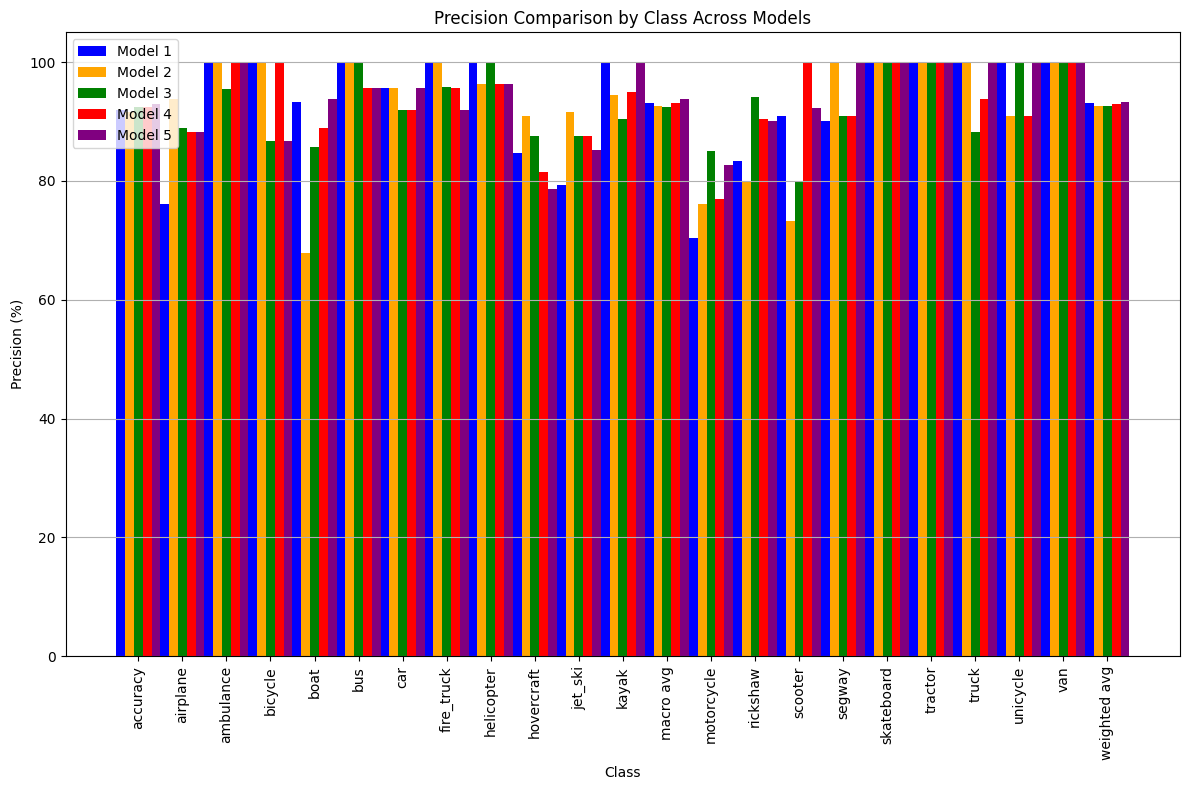

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'class' column is consistent across all DataFrames
precision_df_list = [
    report_df1[['class', 'precision']],
    report_df2[['class', 'precision']],
    report_df3[['class', 'precision']],
    report_df4[['class', 'precision']],
    report_df5[['class', 'precision']]  # Add report_df5
]

# Merge all five DataFrames on 'class' (outer join to preserve all classes)
merged_df = precision_df_list[0]
for i, df in enumerate(precision_df_list[1:], start=2):
    merged_df = merged_df.merge(df, on='class', how='outer', suffixes=('', f'_model{i}'))

# Plotting precision across all models
classes = merged_df['class']
bar_width = 0.2  # Width of each bar
index = np.arange(len(classes))  # X locations for the groups

plt.figure(figsize=(12, 8))

# Plot bars for each DataFrame's precision
bar1 = plt.bar(index, merged_df.iloc[:, 1], bar_width, label='Model 1', color='blue')
bar2 = plt.bar(index + bar_width, merged_df.iloc[:, 2], bar_width, label='Model 2', color='orange')
bar3 = plt.bar(index + 2 * bar_width, merged_df.iloc[:, 3], bar_width, label='Model 3', color='green')
bar4 = plt.bar(index + 3 * bar_width, merged_df.iloc[:, 4], bar_width, label='Model 4', color='red')
bar5 = plt.bar(index + 4 * bar_width, merged_df.iloc[:, 5], bar_width, label='Model 5', color='purple')  # Add Model 5

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Precision (%)')
plt.title('Precision Comparison by Class Across Models')

# Add xticks for each class, centered in the grouped bars
plt.xticks(index + 2 * bar_width, classes, rotation=90)  # Adjust position to center

# Add a grid
plt.grid(axis='y')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [41]:
precision_data = {
    'Model 1': report_df1['precision'],
    'Model 3': report_df3['precision'],
    'Model 5': report_df5['precision']
}

precision_df = pd.DataFrame(precision_data)

recall_data = {
    'Model 1': report_df1['recall'],
    'Model 3': report_df3['recall'],
    'Model 5': report_df5['precision']
}
recall_df = pd.DataFrame(recall_data)

C:\Users\diego\AppData\Local\Temp\ipykernel_4944\951800906.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(precision_df.values, labels=precision_df.columns, patch_artist=True)


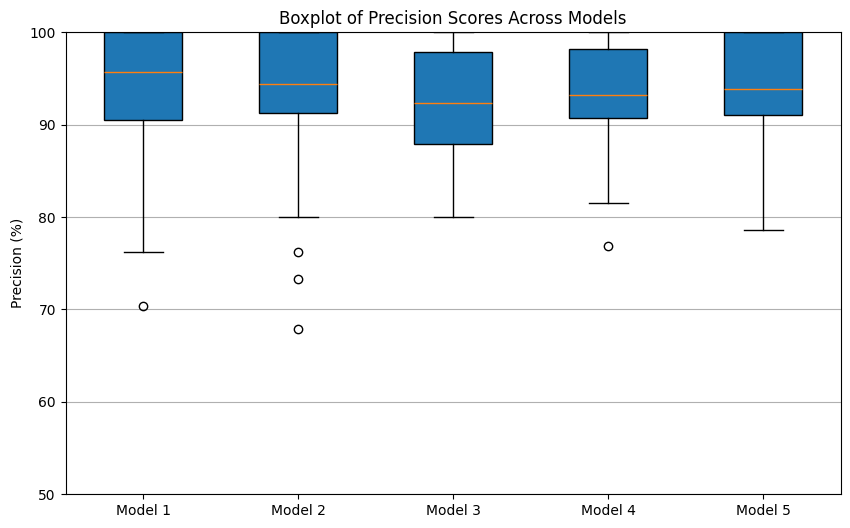

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the DataFrame for plotting


# Create a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(precision_df.values, labels=precision_df.columns, patch_artist=True)

# Customize the plot
plt.title('Boxplot of Precision Scores Across Models')
plt.ylabel('Precision (%)')
plt.grid(axis='y')
plt.ylim(50, 100)

# Show the plot
plt.show()


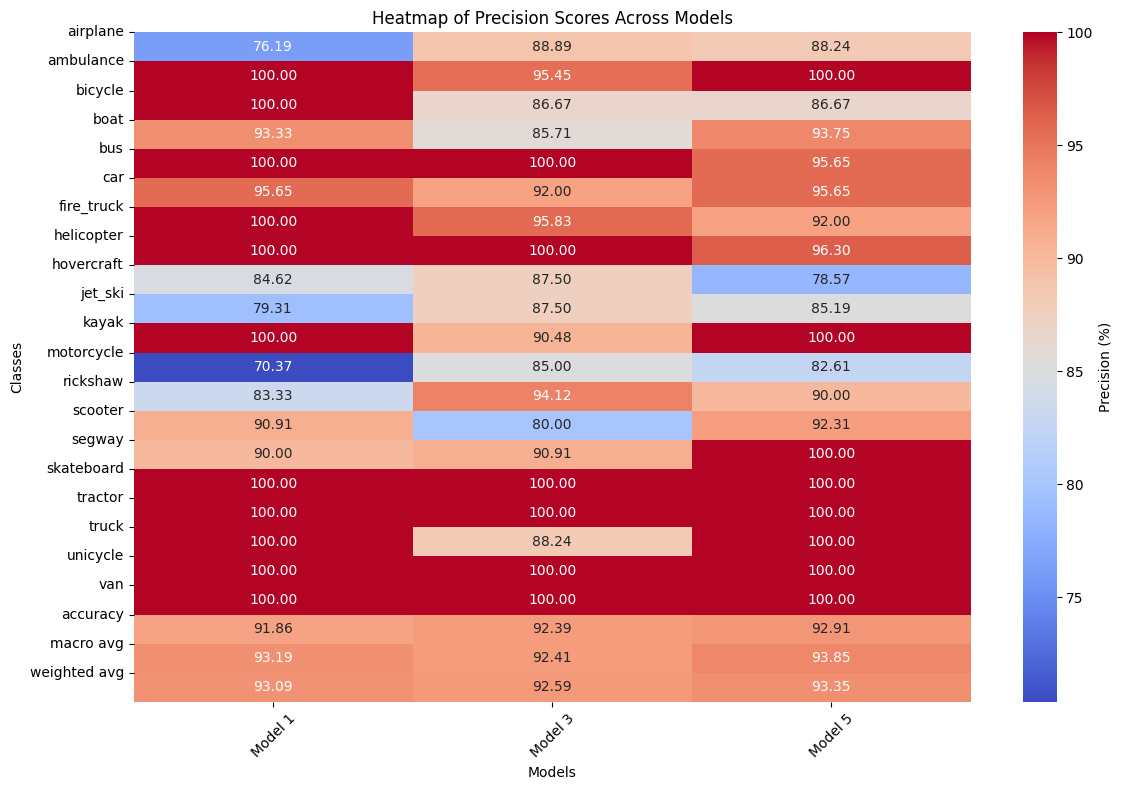

In [36]:
import seaborn as sns

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(precision_df, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Precision (%)'})

# Customize the plot
plt.title('Heatmap of Precision Scores Across Models')
plt.xlabel('Models')
plt.ylabel('Classes')
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(len(report_df1)), labels=report_df1['class'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


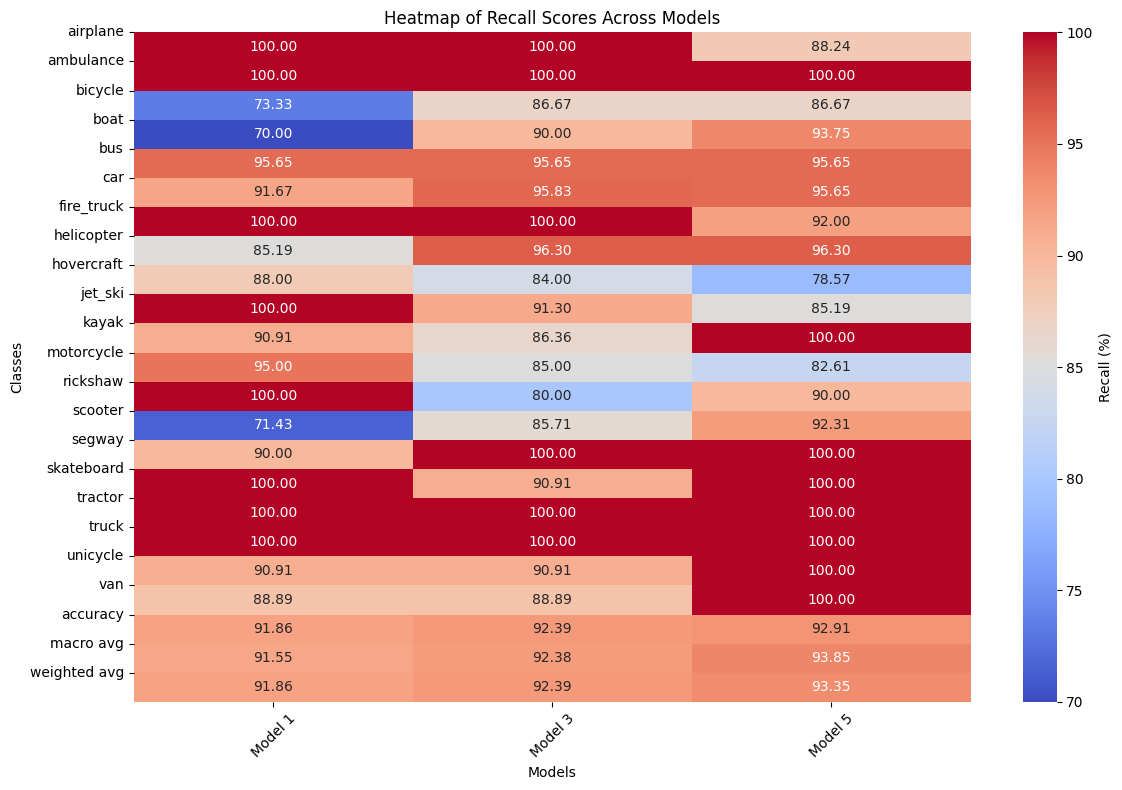

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare the DataFrame for plotting recall



# Create a heatmap for recall
plt.figure(figsize=(12, 8))
sns.heatmap(recall_df, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Recall (%)'})

# Customize the plot
plt.title('Heatmap of Recall Scores Across Models')
plt.xlabel('Models')
plt.ylabel('Classes')
plt.xticks(rotation=45)
plt.yticks(ticks=np.arange(len(report_df1)), labels=report_df1['class'], rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# PLOTEAR LA PRECISION

sorted_df = report_df1.sort_values(by='precision')


plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_df['class'], sorted_df['precision'], color=plt.cm.Blues(sorted_df['precision'] / 100))

# agregar los valores al lado de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}',  
             va='center', ha='left', fontsize=10)

plt.xlabel('Precision (%)')
plt.title('Precision de clasificación de vehículos por clase')
plt.xlim(0, 100) 
plt.grid(axis='x')  
plt.show()

In [ ]:
# PLOTEAR EL RECALL

sorted_df = report_df.sort_values(by='recall')


plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_df['class'], sorted_df['recall'], color=plt.cm.Blues(sorted_df['recall'] / 100))

# agregar los valores al lado de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}',  
             va='center', ha='left', fontsize=10)

plt.xlabel('Recall (%)')
plt.title('Recall de vehículos por clase')
plt.xlim(0, 100) 
plt.grid(axis='x')  
plt.show()

In [ ]:
# ESCRIBIR A UN .txt DETALLES DE LA PRECISION DE CLASE X

# CLASE A ANALIZAR
target_class = 'airplane' 


# Create a DataFrame for detailed predictions
filenames = test_generator.filenames  # List of filenames corresponding to predictions
probabilities = predictions.tolist()  # List of predicted probabilities for each class

# Create a DataFrame for detailed predictions
detailed_predictions = pd.DataFrame({
    'filename': filenames,
    'predicted_class': [class_labels[i] for i in predicted_classes],
    'probabilities': probabilities
}) 

# filtrar el df para la clase especifica
filtered_predictions = detailed_predictions[detailed_predictions['predicted_class'] == target_class].copy()

# formateo de probabilidades, y escribir solo el top 4 de procentajes
def get_top_predictions(probabilities, class_labels, top_n=4):
    top_indices = np.argsort(probabilities)[-top_n:][::-1] 
    top_probs = {class_labels[i]: f"{probabilities[i] * 100:.3f}%" for i in top_indices}
    return top_probs

filtered_predictions['top_probabilities'] = filtered_predictions['probabilities'].apply(
    lambda x: get_top_predictions(x, class_labels)
)

# guardar las predicciones a un .txt
output_path = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/precision_analisis.txt'
with open(output_path, 'w') as f:
    f.write(f"Detailed Predictions for '{target_class}' Class:\n\n")
    for index, row in filtered_predictions.iterrows():
        f.write(f"Filename: {row['filename']}\n")
        f.write(f"Predicted Class: {row['predicted_class']}\n")
        f.write("Top Probabilities:\n")
        for class_name, probability in row['top_probabilities'].items():
            f.write(f"  {class_name}: {probability}\n")
        f.write("\n")  # Blank line between predictions

print(f'Precision analysis for class "{target_class}" saved to {output_path}')

In [ ]:
# ESCRIBIR A UN .txt DETALLES DEL RECALL DE CLASE X

# CLASE A ANALIZAR
target_class = 'truck'

# Create a DataFrame for detailed predictions
filenames = test_generator.filenames  # List of filenames corresponding to predictions
probabilities = predictions.tolist()  # List of predicted probabilities for each class

# Create a DataFrame for detailed predictions
detailed_predictions = pd.DataFrame({
    'filename': filenames,
    'actual_class': [class_labels[i] for i in true_classes],
    'predicted_class': [class_labels[i] for i in predicted_classes],
    'probabilities': probabilities
})

# Filter the DataFrame for instances of the target class
filtered_recall = detailed_predictions[detailed_predictions['actual_class'] == target_class].copy()

# Function to get the top N predictions
def get_top_predictions(probabilities, class_labels, top_n=4):
    top_indices = np.argsort(probabilities)[-top_n:][::-1]  # Get the indices of the top N probabilities
    top_probs = {class_labels[i]: f"{probabilities[i] * 100:.2f}%" for i in top_indices}
    return top_probs

# Add a column for top predictions
filtered_recall['top_probabilities'] = filtered_recall['probabilities'].apply(
    lambda x: get_top_predictions(x, class_labels)
)

# Save the recall analysis to a .txt file
output_path_recall = r'C:/Users/diego/Desktop/TSCDIA/Modelizado de Sistemas de IA/TP1/Modelizado/recall_analysis.txt'
with open(output_path_recall, 'w') as f:
    f.write(f"Recall Analysis for '{target_class}' Class:\n\n")
    for index, row in filtered_recall.iterrows():
        f.write(f"Filename: {row['filename']}\n")
        f.write(f"Predicted Class: {row['predicted_class']}\n")
        f.write("Top Probabilities:\n")
        for class_name, probability in row['top_probabilities'].items():
            f.write(f"  {class_name}: {probability}\n")
        f.write("\n")  # Blank line between predictions

print(f'Recall analysis for class "{target_class}" saved to {output_path_recall}')


In [ ]:
# ver si hay relacion entre el numero de imagenes de muestra y los valores de precision o recall


precision = report_df['precision']
support = report_df['support']
classes = report_df['class']

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(support, precision, color='blue', s=100, alpha=0.6)

# Label each point with the class name
for i, class_name in enumerate(report_df['class']):
    plt.text(support.iloc[i], precision.iloc[i], class_name, fontsize=9, ha='right')

# Add titles and labels
plt.title('Precision vs Support for Each Class', fontsize=14)
plt.xlabel('Support (Number of Samples)', fontsize=12)
plt.ylabel('Precision (%)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()


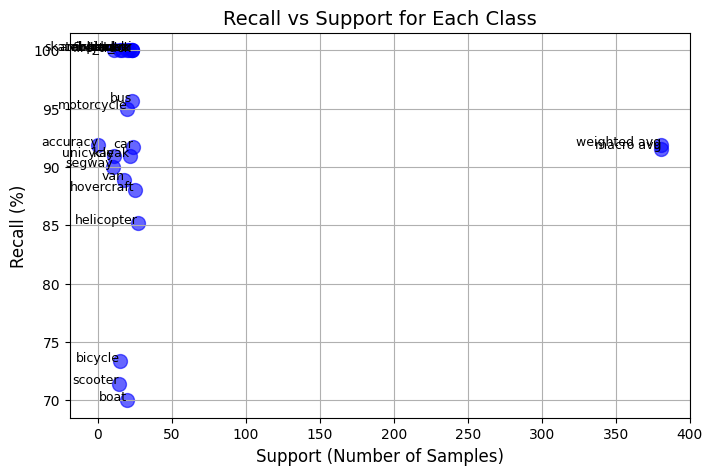

In [44]:
# recall

support = report_df1['support']
recall = report_df1['recall']
classes = report_df1['class']

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(support, recall, color='blue', s=100, alpha=0.6)

# Label each point with the class name
for i, class_name in enumerate(classes):
    plt.text(support.iloc[i], recall.iloc[i], class_name, fontsize=9, ha='right')

# Add titles and labels
plt.title('Recall vs Support for Each Class', fontsize=14)
plt.xlabel('Support (Number of Samples)', fontsize=12)
plt.ylabel('Recall (%)', fontsize=12)
plt.grid(True)

# Show plot
plt.show()
